In [329]:
import pandas as pd
commodity = 'corn'
import utils
import numpy as np
import matplotlib.pyplot as plt
import torch

In [330]:
# note: edited 12/30/2015

In [331]:
import dataloader_cm
import LSTM

In [332]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [395]:
    # read csvs and combine into single dataframe
read_csv = pd.read_csv(f'data/commodities.csv', header = 0)

In [396]:
[x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')]

['_BCOMD_Close',
 'CMECFODM_Close',
 '__CC1_ID_Vol',
 '__SC1_ID_Close',
 '__SC1_ID_Vol',
 '__C_US2D_Close',
 '__WTC_D_Close',
 '_BO1599D_Close',
 '__SYB_TD_Close',
 'BRT_D_Close',
 'CMCORNM_Close',
 'CMSCORNM_Close']

In [417]:
testdl = dataloader_cm.CommoditiesExogenousDataSet(filepath='commodities', seq_length= 20, split = 'train', pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

In [600]:
tnew = LSTM.CommodityLSTM(num_features =13)

In [433]:
tnew.forward(testdl[0][0].unsqueeze(0).float())

(tensor([[0.1667]], grad_fn=<AddmmBackward0>),
 tensor([[0.5416]], grad_fn=<SigmoidBackward0>))

In [594]:
tt = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length= 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

In [595]:
for step, batch in enumerate(tt):
    X, y = batch
    break

In [602]:
tnew.forward(X.float())

tensor([[0.6119],
        [0.6187],
        [0.6190],
        [0.6151],
        [0.6043],
        [0.5954],
        [0.6174],
        [0.6144],
        [0.6107],
        [0.6180]], grad_fn=<AddmmBackward0>)

In [597]:
y.shape

torch.Size([10, 2])

In [598]:
X.shape

torch.Size([10, 30, 13])

In [502]:
nn_output.shape

torch.Size([2, 1])

In [521]:
yn[:, 1, :]

tensor([[ 0.0074],
        [-0.0095]])

In [522]:
import torch.nn as nn

nn_output, logit = tnew.forward(X.float())

mseloss = nn.MSELoss()
bceloss = nn.BCELoss()

batch_loss = mseloss(nn_output, yn[:, 1, :])
classification_loss = bceloss(logit, yn[:, 0, :])
totalloss = batch_loss + classification_loss

In [523]:
batch_loss

tensor(0.0186, grad_fn=<MseLossBackward0>)

In [520]:
classification_loss

tensor(0.6892, grad_fn=<BinaryCrossEntropyBackward0>)

# MULTI TASK

In [557]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

testlstm = LSTM.CommodityLSTM(num_features = 13, )
train_losses, _ = testlstm.train(train_loader, epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.7684251666069031
TRAINING BATCH LOSS AT STEP 700: 0.6868513822555542


 20%|██        | 1/5 [00:16<01:04, 16.17s/it]

TRAINING BATCH LOSS AT STEP 0: 0.6932423710823059
TRAINING BATCH LOSS AT STEP 700: 0.7033482193946838


 40%|████      | 2/5 [00:33<00:50, 16.98s/it]

TRAINING BATCH LOSS AT STEP 0: 0.7015630602836609
TRAINING BATCH LOSS AT STEP 700: 0.7061594724655151


 60%|██████    | 3/5 [00:49<00:32, 16.50s/it]

TRAINING BATCH LOSS AT STEP 0: 0.6931735277175903
TRAINING BATCH LOSS AT STEP 700: 0.6925539374351501


 80%|████████  | 4/5 [01:05<00:16, 16.25s/it]

TRAINING BATCH LOSS AT STEP 0: 0.6861972808837891
TRAINING BATCH LOSS AT STEP 700: 0.6849244832992554


100%|██████████| 5/5 [01:20<00:00, 16.10s/it]


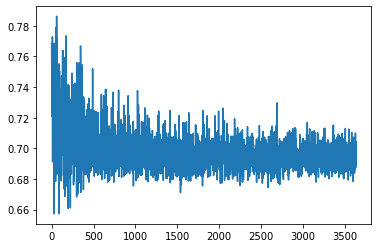

In [558]:
plt.plot([x.detach().numpy() for x in train_losses])

In [623]:
def validate_model(model, split='val', seq_length = 30, exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')]):
    from torch.utils.data import dataset, dataloader, SequentialSampler
    dl = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length= seq_length, split = split, batch_size = 1, pxcol = '__CC1_ID_Close', exog = exog, dateformat = '%m/%d/%Y')


    predictions, val_losses, actuals = model.test(dl)
    predictions = predictions.flatten()
    actuals = np.array(actuals)

    from backtester import backtest_log
    scaled_returns, actual_returns, strategy_predictors = backtest_log(predictions, actuals)
    return scaled_returns, actual_returns, strategy_predictors

AVERAGE LOSS:  0.69399
Long only annualized psuedo sharpe:  0.047245367810432544
Strategy annualized psuedo sharpe:  0.5424821098023596
Correlation matrix between strategy predictors and returns
[[1.         0.04802418]
 [0.04802418 1.        ]]
Avg. Portfolio Allocation,  0.03162249
Percent of time predicted direction correctly:  47.18900343642612
Percent of time long:  45.786941580756015


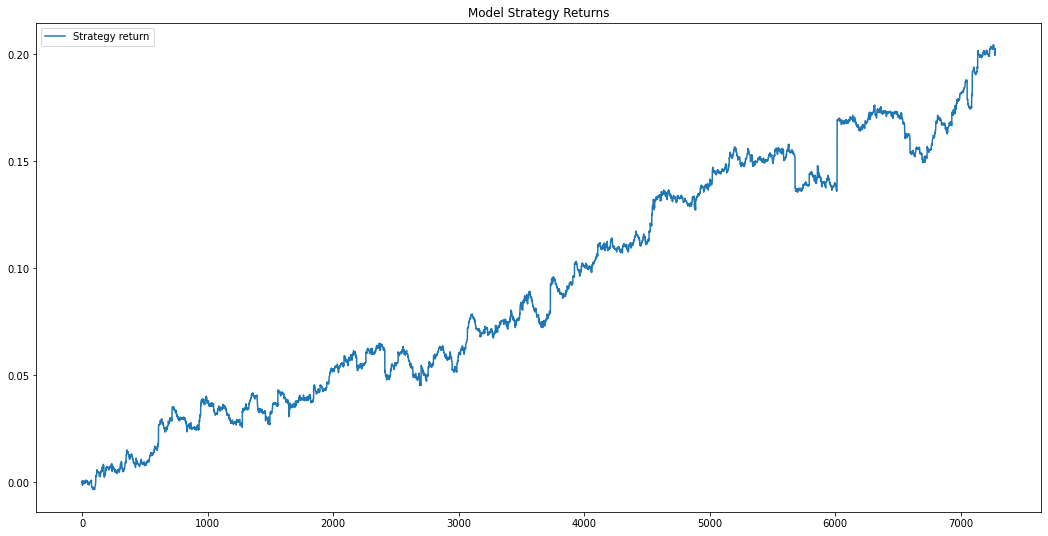

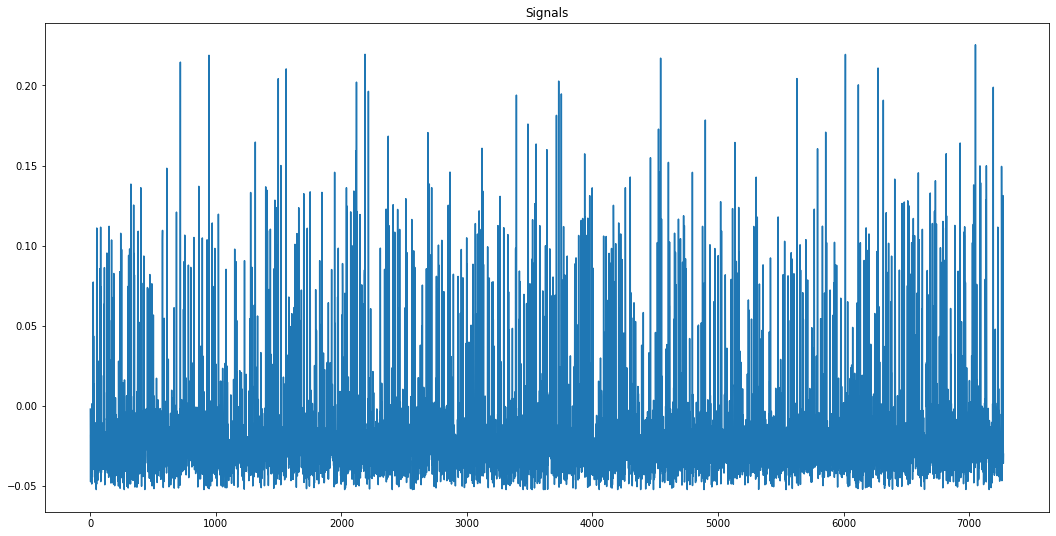

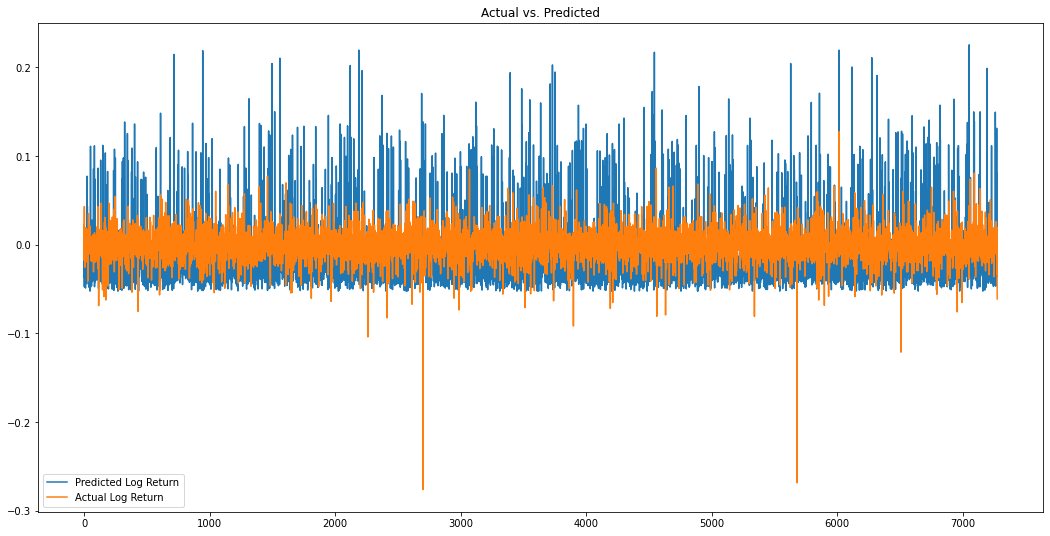

In [572]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train')

In [573]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.335
Date:                Sun, 28 Nov 2021   Prob (F-statistic):             0.0374
Time:                        19:34:26   Log-Likelihood:                 19548.
No. Observations:                7275   AIC:                        -3.909e+04
Df Residuals:                    7273   BIC:                        -3.908e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.859      0.390      -0.000       0.001
x1            -4.1003      1.969     -2.082      0.037      -7.960      -0.240
==============================================================================
Omnibus:                     2963.407   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           440507.018
Skew:                          -0.889   Prob(JB):                         0.00
Kurtosis:                      41.080   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

AVERAGE LOSS:  0.69526595
Long only annualized psuedo sharpe:  0.0735615363807346
Strategy annualized psuedo sharpe:  1.7465626244459007
Correlation matrix between strategy predictors and returns
[[1.         0.15487047]
 [0.15487047 1.        ]]
Avg. Portfolio Allocation,  0.040782213
Percent of time predicted direction correctly:  46.00760456273764
Percent of time long:  41.06463878326996


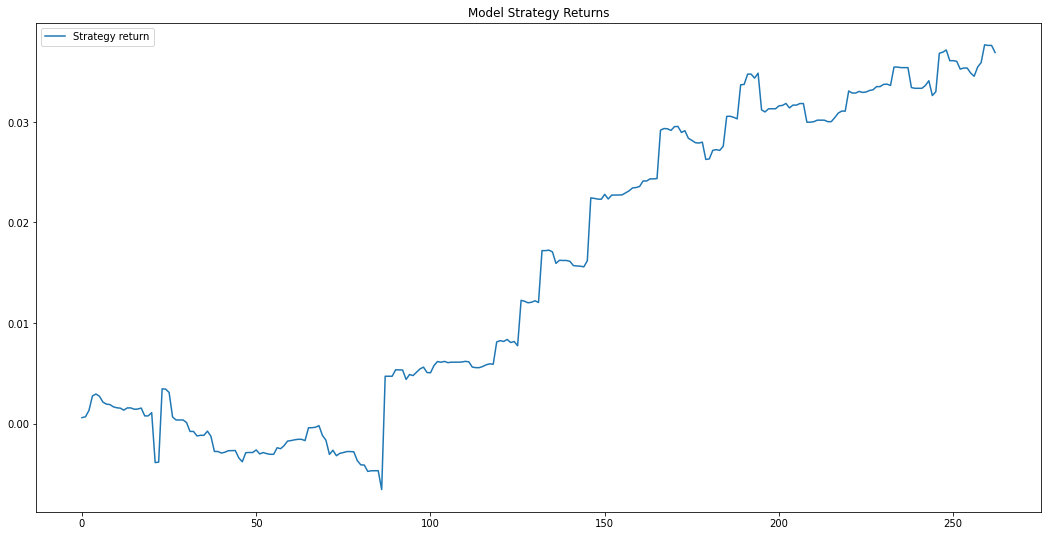

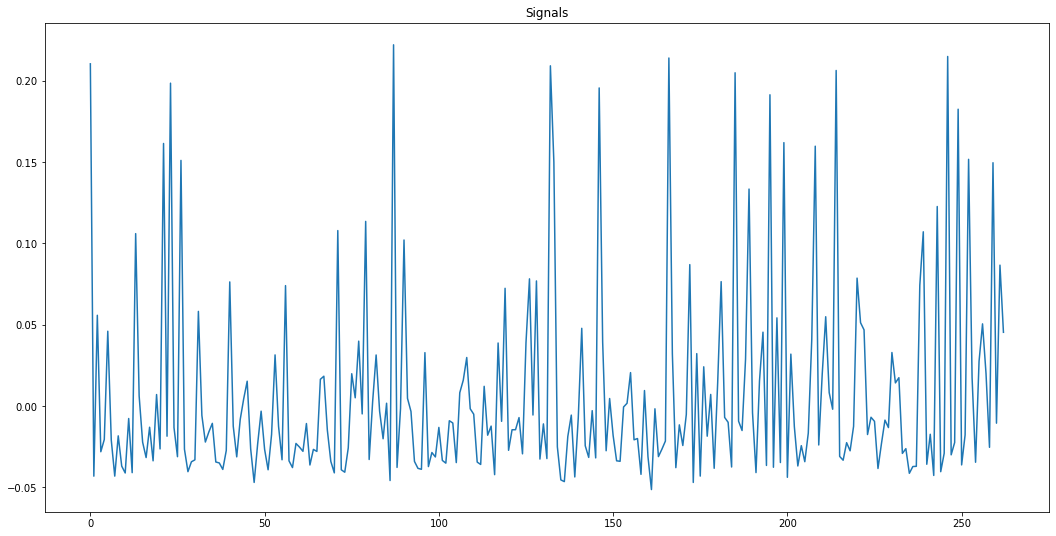

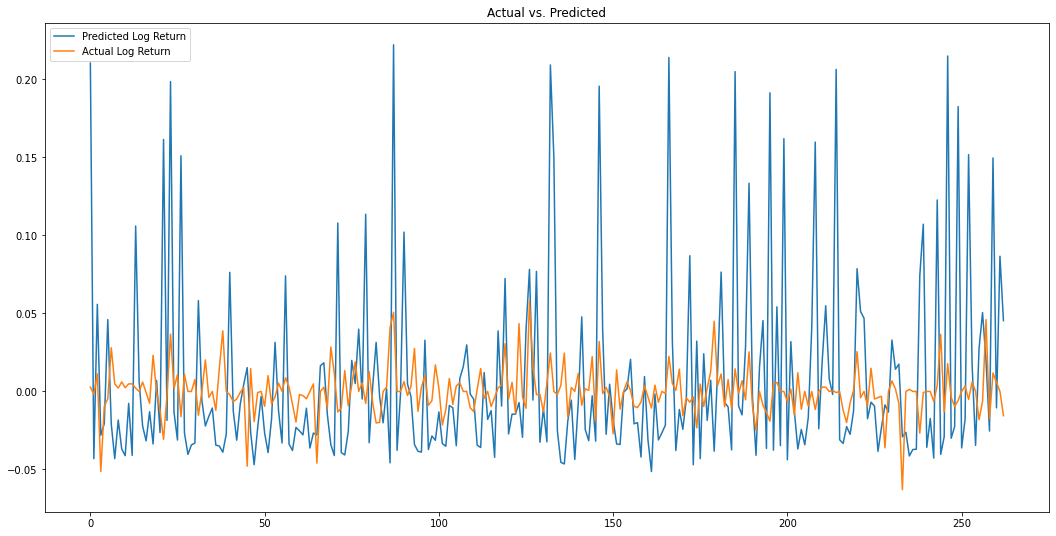

In [570]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test')

In [571]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     17.86
Date:                Sun, 28 Nov 2021   Prob (F-statistic):           3.29e-05
Time:                        19:29:13   Log-Likelihood:                 743.94
No. Observations:                 263   AIC:                            -1484.
Df Residuals:                     261   BIC:                            -1477.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.524      0.600      -0.002       0.001
x1             3.4184      0.809      4.226      0.000       1.833       5.004
==============================================================================
Omnibus:                       35.106   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.140
Skew:                          -0.073   Prob(JB):                     7.15e-53
Kurtosis:                       7.679   Cond. No.                         784.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

# NON MULTI TASK WITH EXOGENOUS

In [574]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

testlstm = LSTM.CommodityLSTM(num_features = 13, )
train_losses, _ = testlstm.train(train_loader, epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.24149218201637268
TRAINING BATCH LOSS AT STEP 700: 0.09327125549316406


 20%|██        | 1/5 [00:15<01:02, 15.50s/it]

TRAINING BATCH LOSS AT STEP 0: 0.06085359305143356
TRAINING BATCH LOSS AT STEP 700: 0.037023067474365234


 40%|████      | 2/5 [00:30<00:46, 15.42s/it]

TRAINING BATCH LOSS AT STEP 0: 0.02552376314997673
TRAINING BATCH LOSS AT STEP 700: 0.014990334399044514


 60%|██████    | 3/5 [00:45<00:30, 15.26s/it]

TRAINING BATCH LOSS AT STEP 0: 0.1360548585653305
TRAINING BATCH LOSS AT STEP 700: 0.014442105777561665


 80%|████████  | 4/5 [01:00<00:15, 15.06s/it]

TRAINING BATCH LOSS AT STEP 0: 0.01169239915907383
TRAINING BATCH LOSS AT STEP 700: 0.0028159464709460735


100%|██████████| 5/5 [01:15<00:00, 15.10s/it]


AVERAGE LOSS:  0.011064479
Long only annualized psuedo sharpe:  0.0472454010750795
Strategy annualized psuedo sharpe:  -0.0835192271340229
Correlation matrix between strategy predictors and returns
[[ 1.         -0.00455985]
 [-0.00455985  1.        ]]
Avg. Portfolio Allocation,  0.064431615
Percent of time predicted direction correctly:  45.33333333333333
Percent of time long:  45.786941580756015


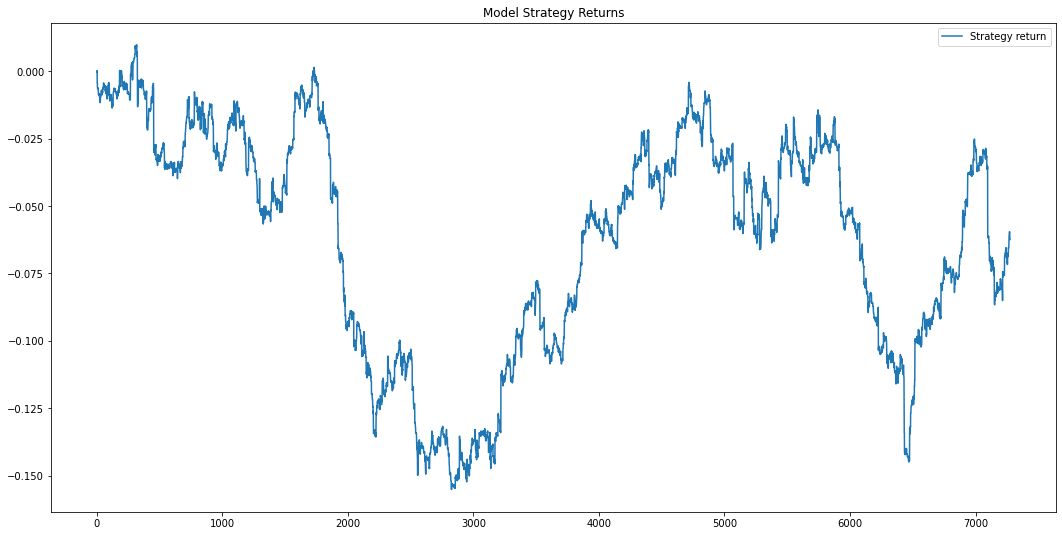

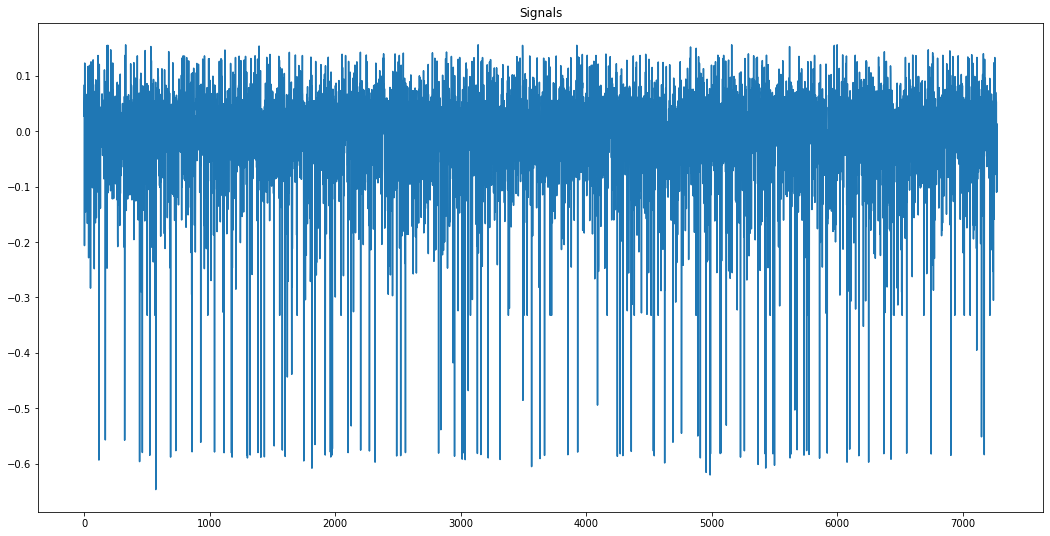

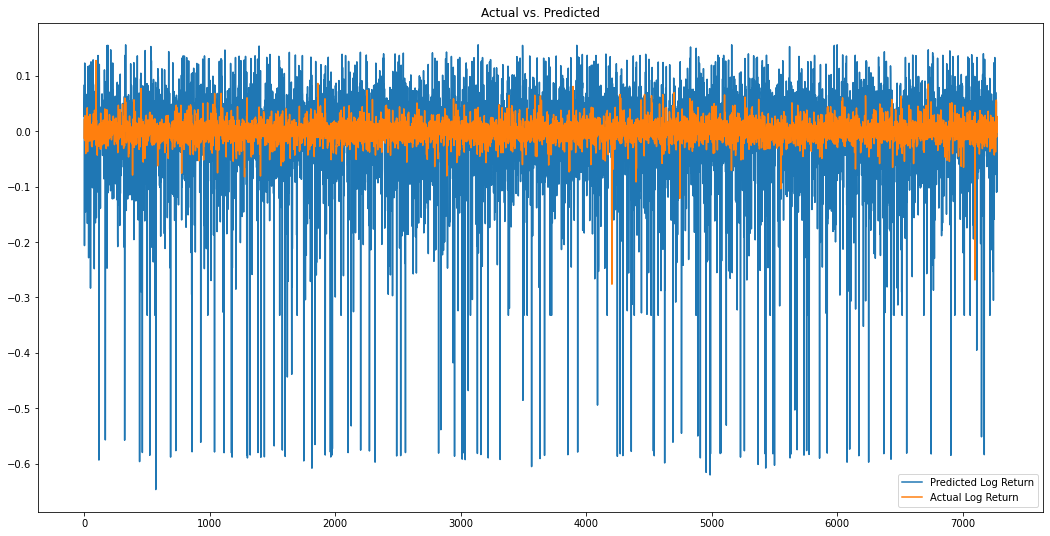

In [575]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train')

In [576]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.622
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.203
Time:                        19:42:03   Log-Likelihood:                 19415.
No. Observations:                7275   AIC:                        -3.883e+04
Df Residuals:                    7273   BIC:                        -3.881e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.471e-05      0.000      0.226      0.821      -0.000       0.000
x1            -0.6194      0.486     -1.273      0.203      -1.573       0.334
==============================================================================
Omnibus:                     3057.139   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           172050.955
Skew:                          -1.220   Prob(JB):                         0.00
Kurtosis:                      26.699   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

AVERAGE LOSS:  0.005892402
Long only annualized psuedo sharpe:  0.07356159551788474
Strategy annualized psuedo sharpe:  -1.2983843990463715
Correlation matrix between strategy predictors and returns
[[ 1.         -0.09696298]
 [-0.09696298  1.        ]]
Avg. Portfolio Allocation,  0.061765112
Percent of time predicted direction correctly:  37.6425855513308
Percent of time long:  41.06463878326996


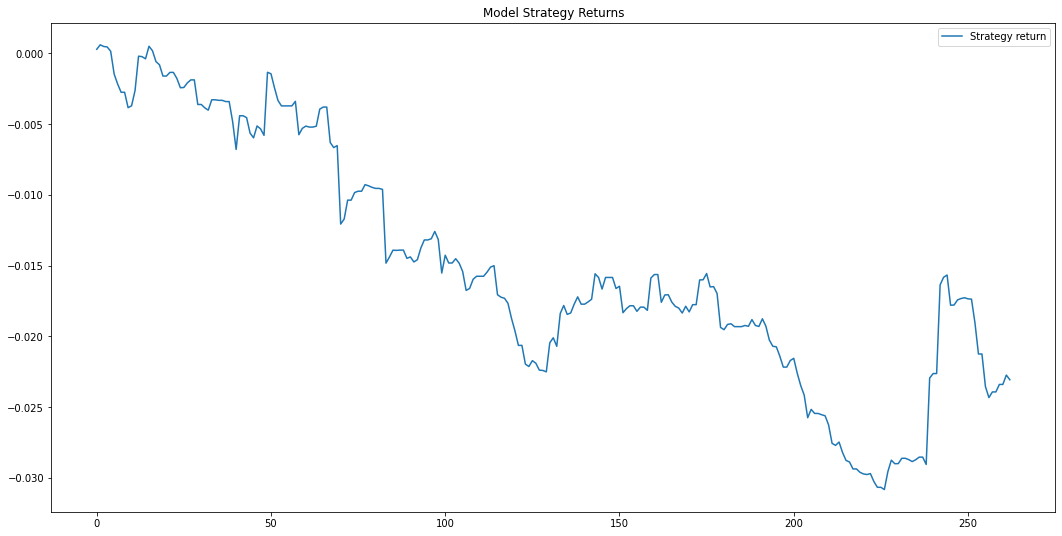

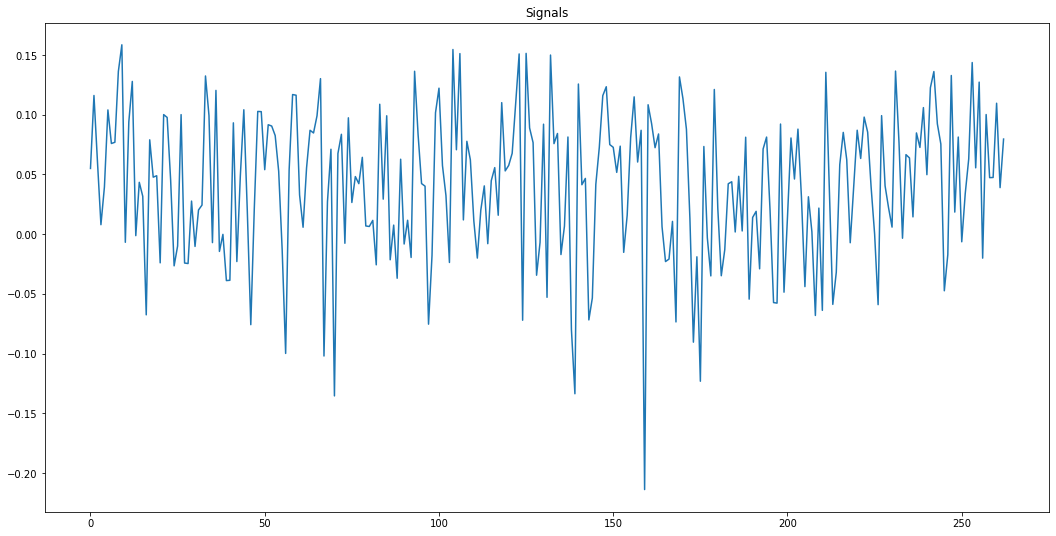

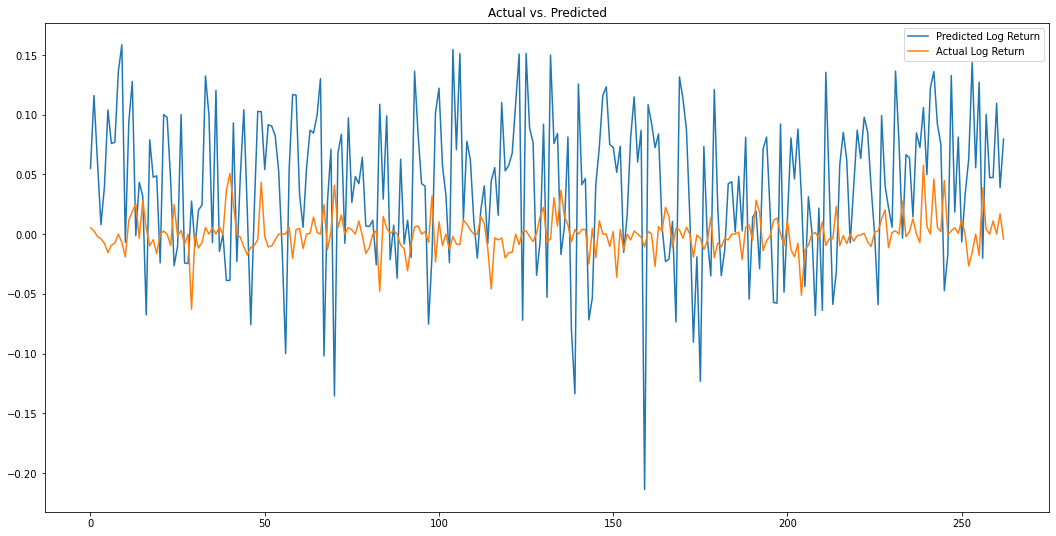

In [577]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test')

In [578]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     10.11
Date:                Sun, 28 Nov 2021   Prob (F-statistic):            0.00165
Time:                        19:43:44   Log-Likelihood:                 757.22
No. Observations:                 263   AIC:                            -1510.
Df Residuals:                     261   BIC:                            -1503.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.625      0.532      -0.001       0.002
x1             5.7948      1.823      3.179      0.001       2.223       9.367
==============================================================================
Omnibus:                       91.031   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              578.435
Skew:                           1.222   Prob(JB):                    2.48e-126
Kurtosis:                       9.842   Cond. No.                         932.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

# ONE TIME SERIES

In [618]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [], dateformat = '%m/%d/%Y')

/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)
/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


In [622]:
testlstm = LSTM.CommodityLSTM(num_features = 1)
train_losses, _ = testlstm.train(train_loader, epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.2096600979566574
TRAINING BATCH LOSS AT STEP 700: 0.06250302493572235


 20%|██        | 1/5 [00:15<01:02, 15.51s/it]

TRAINING BATCH LOSS AT STEP 0: 0.06025053933262825
TRAINING BATCH LOSS AT STEP 700: 0.0017057470977306366


 40%|████      | 2/5 [00:30<00:46, 15.39s/it]

TRAINING BATCH LOSS AT STEP 0: 0.0011121623683720827
TRAINING BATCH LOSS AT STEP 700: 0.0001658349938225001


 60%|██████    | 3/5 [00:46<00:30, 15.45s/it]

TRAINING BATCH LOSS AT STEP 0: 0.0008635303820483387
TRAINING BATCH LOSS AT STEP 700: 0.0003351909981574863


 80%|████████  | 4/5 [01:02<00:15, 15.57s/it]

TRAINING BATCH LOSS AT STEP 0: 0.00033757550409063697
TRAINING BATCH LOSS AT STEP 700: 0.00011687081132549793


100%|██████████| 5/5 [01:18<00:00, 15.63s/it]


/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


AVERAGE LOSS:  0.00030110322
Long only annualized psuedo sharpe:  0.04724539737900762
Strategy annualized psuedo sharpe:  -0.21714477021653028
Correlation matrix between strategy predictors and returns
[[ 1.         -0.01739874]
 [-0.01739874  1.        ]]
Avg. Portfolio Allocation,  0.0028407983
Percent of time predicted direction correctly:  45.62199312714776
Percent of time long:  45.786941580756015


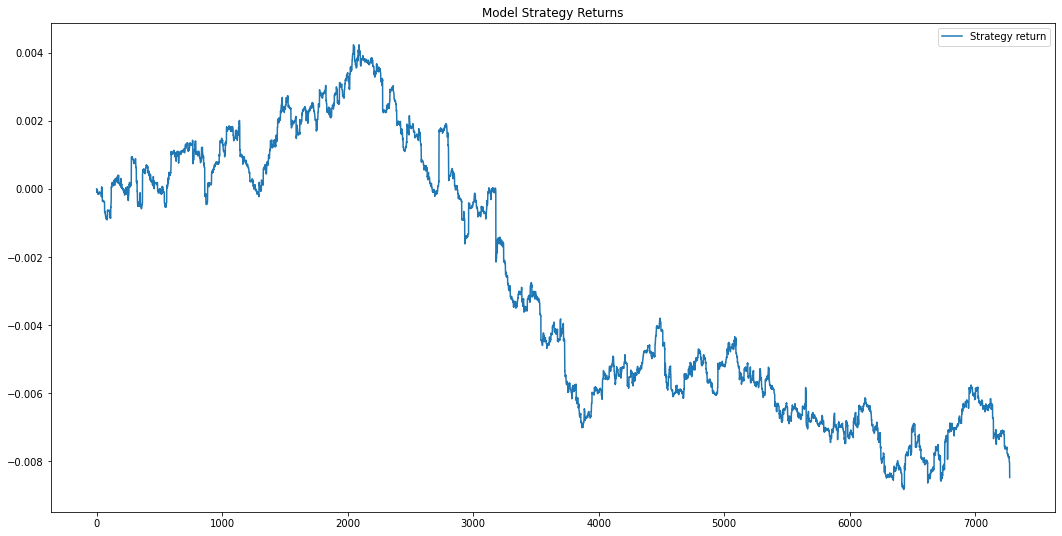

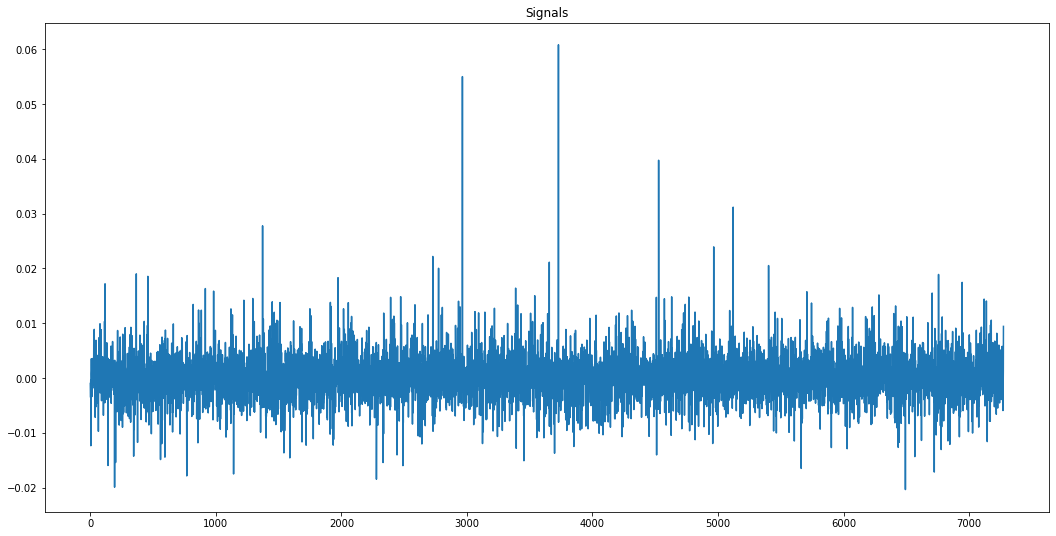

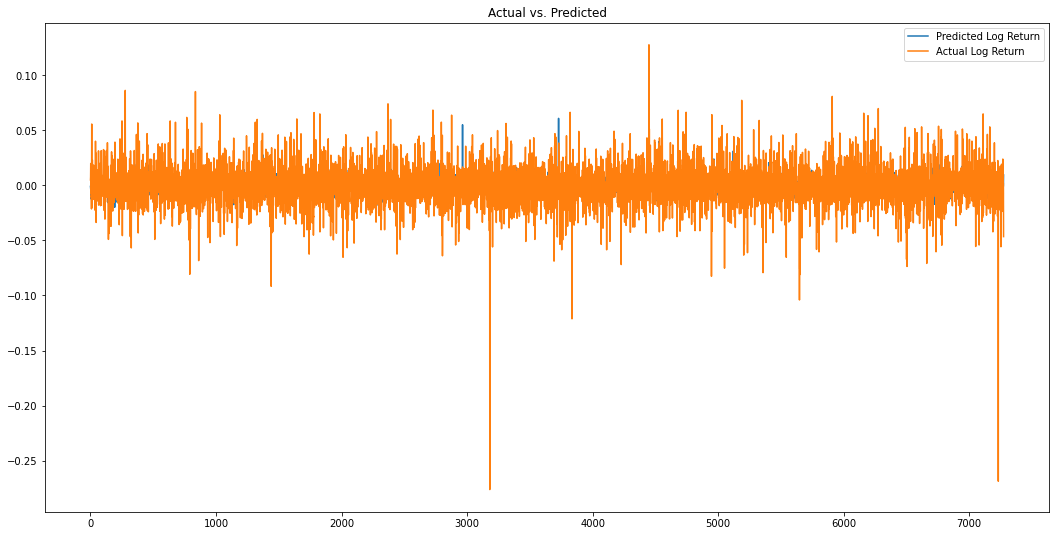

In [624]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train', exog = [])

In [625]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     8.602
Date:                Sun, 28 Nov 2021   Prob (F-statistic):            0.00337
Time:                        20:01:37   Log-Likelihood:                 19487.
No. Observations:                7275   AIC:                        -3.897e+04
Df Residuals:                    7273   BIC:                        -3.896e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.487e-05      0.000      0.448      0.654      -0.000       0.000
x1            29.8846     10.190      2.933      0.003       9.914      49.856
==============================================================================
Omnibus:                     2147.671   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70696.219
Skew:                          -0.766   Prob(JB):                         0.00
Kurtosis:                      18.195   Cond. No.                     1.17e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 1.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


AVERAGE LOSS:  0.00024528286
Long only annualized psuedo sharpe:  0.0735616029100285
Strategy annualized psuedo sharpe:  -0.9759323462319516
Correlation matrix between strategy predictors and returns
[[ 1.        -0.0723764]
 [-0.0723764  1.       ]]
Avg. Portfolio Allocation,  0.0026296075
Percent of time predicted direction correctly:  42.20532319391635
Percent of time long:  41.06463878326996


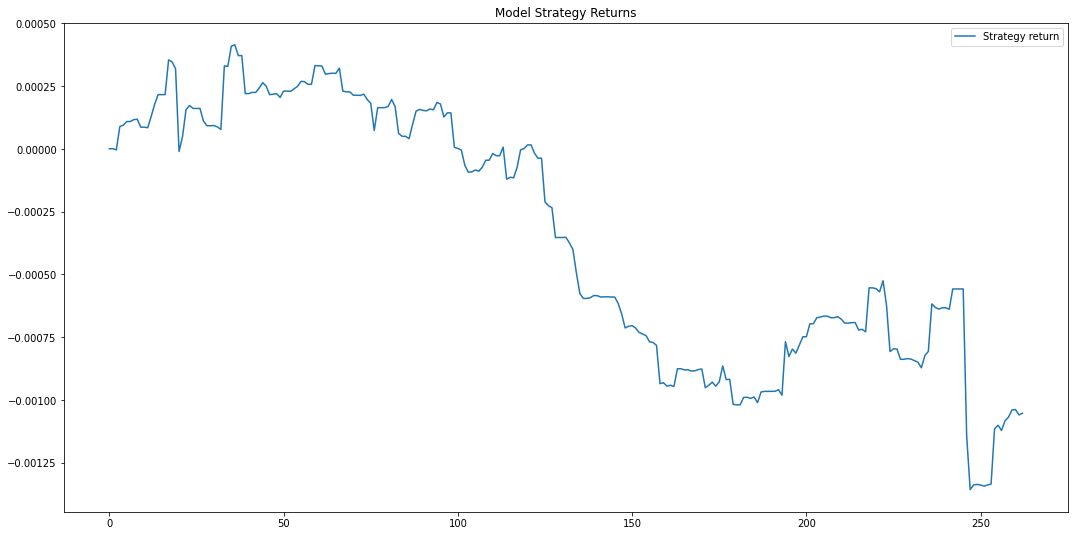

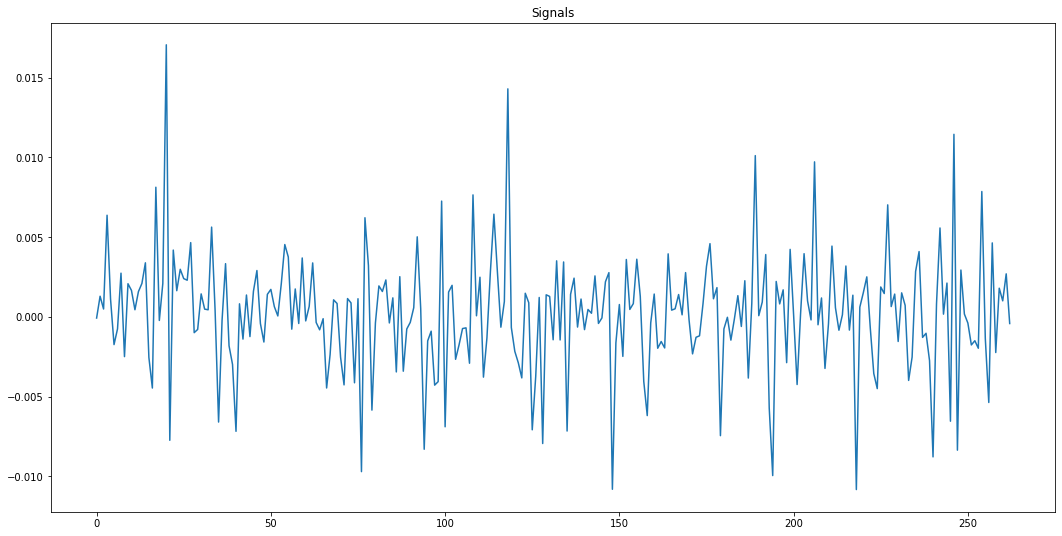

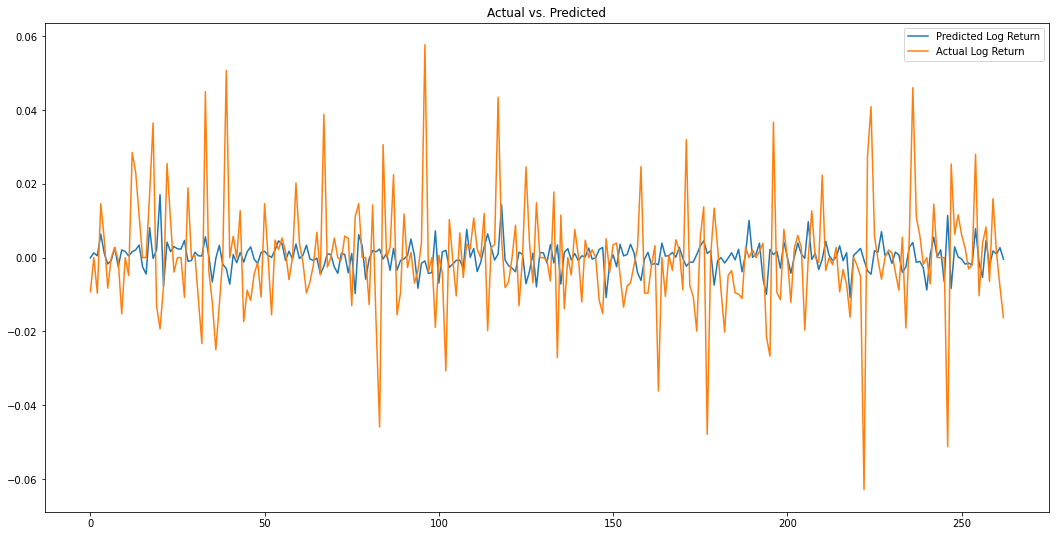

In [626]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test', exog = [])

In [627]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_returns)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.355
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.126
Time:                        20:02:02   Log-Likelihood:                 736.00
No. Observations:                 263   AIC:                            -1468.
Df Residuals:                     261   BIC:                            -1461.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.300      0.764      -0.001       0.002
x1            38.4594     25.063      1.535      0.125     -10.662      87.581
==============================================================================
Omnibus:                       37.826   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.155
Skew:                           0.465   Prob(JB):                     1.67e-35
Kurtosis:                       6.708   Cond. No.                     1.54e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 1.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
dd